In [1]:
library(tidyverse)
library(repr)
options(repr.matrix.max.rows = 6)
library(ggplot2)
library(tidymodels)
library(dplyr)
library(themis)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

**Proposed specific question:** does played_hours influence whether or not people subscribe?
Can we predict whether or not someone will subscribe to the newsletter based on how much they've played in Plaicraft?

In [2]:
set.seed(12)

players <- read_csv("data/players.csv")
sessions <- read_csv("data/sessions.csv")
players

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


In [3]:
set.seed(12)

mod_players <- players |>
                select (subscribe, played_hours, experience) |>
                mutate (subscribe = as_factor(subscribe),
                        experience = recode(experience, Beginner = 1, Amateur = 2, Regular = 3, Pro = 4, Veteran = 5)) 
mod_players

subscribe,played_hours,experience
<fct>,<dbl>,<dbl>
TRUE,30.3,4
TRUE,3.8,5
FALSE,0.0,5
⋮,⋮,⋮
FALSE,0.0,2
FALSE,2.3,2
TRUE,0.2,4


neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.5175041,5,0.03025870,Preprocessor1_Model01
2,roc_auc,binary,0.5217339,5,0.02833102,Preprocessor1_Model01
3,accuracy,binary,0.4361084,5,0.04112917,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
99,roc_auc,binary,0.4969968,5,0.04611618,Preprocessor1_Model98
100,accuracy,binary,0.5015928,5,0.06433796,Preprocessor1_Model99
100,roc_auc,binary,0.4894365,5,0.04309054,Preprocessor1_Model99


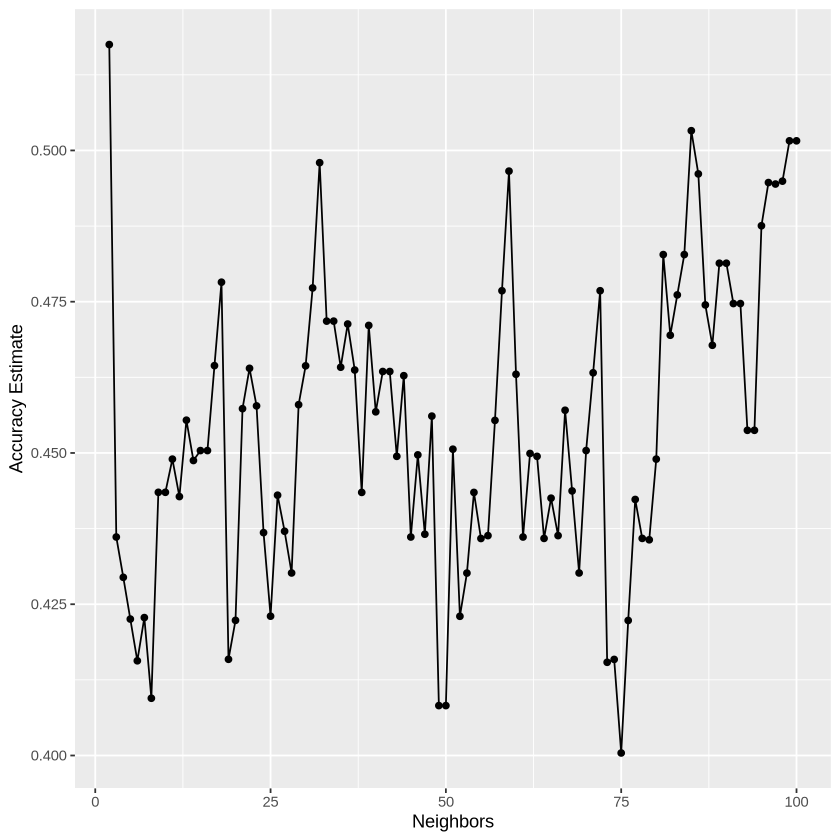

In [4]:
# K-nn Tuning + upsample
set.seed(12)
players_split <- mod_players |> 
                    initial_split (prop = 0.75, strata = subscribe) 

players_training <- training (players_split)
players_testing <- testing (players_split)

recipe_with_step <- recipe(subscribe ~ ., data = players_training) |>
                        step_center(all_predictors()) |>
                        step_scale(all_predictors()) |>
                        step_upsample (subscribe , over_ratio = 1) 

knn_spec_tune <- nearest_neighbor (weight_func = "rectangular", neighbors = tune()) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

vfold <- vfold_cv(players_training, v = 5, strata = subscribe)

knn_grid <- tibble(neighbors = seq(from = 2, to = 100, by = 1))

knn_results <- workflow() |>
                  add_recipe(recipe_with_step) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = vfold, grid = knn_grid)|>
                  collect_metrics()

knn_results
# Fix issue with extracting neighbors and mean accuracy
accuracies <- knn_results |>
                  filter(.metric == "accuracy") |>
                  select(neighbors, mean = mean) |>  # Ensure correct column selection
                  mutate(neighbors = as.numeric(neighbors), mean = as.numeric(mean))

# Plot accuracy vs. number of neighbors
cross_val_plot <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = "Neighbors", 
                       y = "Accuracy Estimate") 
             
cross_val_plot

In [5]:
set.seed(12)
precision_recipe <- recipe(subscribe ~ ., data = players_training) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors()) 

# for 2 neighbors
knn_2 <- nearest_neighbor (weight_func = "rectangular", neighbors = 2) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_2 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_2) |>
    fit(data = players_training)

predictions_2 <- predict (fit_2, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_2 <- predictions_2 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_2 <- predictions_2 |>
    conf_mat (truth = subscribe, estimate = .pred_class) 

conf_mat_2

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

In [6]:
set.seed(12)
#for 4 neighbors

knn_4 <- nearest_neighbor (weight_func = "rectangular", neighbors = 4) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_4 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_4) |>
    fit(data = players_training)

predictions_4 <- predict (fit_4, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_4 <- predictions_4 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_4 <- predictions_4 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_4

          Truth
Prediction FALSE TRUE
     FALSE    10   26
     TRUE      3   10

In [7]:
set.seed(12)
#for 6 neighbors

knn_6 <- nearest_neighbor (weight_func = "rectangular", neighbors = 6) |>
    set_engine("kknn") |>
    set_mode ("classification")

fit_6 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_6) |>
    fit(data = players_training)

predictions_6 <- predict (fit_6, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_6 <- predictions_6 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_6 <- predictions_6 |>
    conf_mat (truth = subscribe, estimate = .pred_class)
conf_mat_6

          Truth
Prediction FALSE TRUE
     FALSE     9   23
     TRUE      4   13

In [8]:
set.seed(12)
#for 10 neighbors

knn_10 <- nearest_neighbor (weight_func = "rectangular", neighbors = 10) |>
                    set_engine("kknn") |>
                    set_mode ("classification")

fit_10 <- workflow() |>
    add_recipe (precision_recipe) |>
    add_model (knn_10) |>
    fit(data = players_training)

predictions_10 <- predict (fit_10, new_data = players_testing) |>
    bind_cols (players_testing)

metrics_10 <- predictions_10 |>
    metrics(truth = subscribe, estimate = .pred_class)

conf_mat_10 <- predictions_10 |>
    conf_mat (truth = subscribe, estimate = .pred_class)

conf_mat_10

          Truth
Prediction FALSE TRUE
     FALSE     4   16
     TRUE      9   20

In [9]:
set.seed(12)

precision_2 <- 10/(10 + 21)
recall_2 <- 10/(10 + 3)

precision_3 <- 5/(5 + 18)
recall_3 <- 5/(5 + 8)

precision_4 <- 7/(7 + 21)
recall_4 <- 7/(7 + 6)

precision_6 <- 7/(7 + 19)
recall_6 <- 7/(7 + 6)

precision_10 <- 4/(4 + 10)
recall_10 <- 4/(4 + 9)

metrics_df <- tibble("k" = c(2, 3, 4, 6, 10), 
                     "precision" = c(precision_2, precision_3, precision_4, precision_6, precision_10),
                     "recall" = c(recall_2, recall_3, recall_4, recall_6, recall_10))
metrics_df

max_recall <- metrics_df |>
    select(k, recall) |>
    arrange(desc(recall)) |>
    slice(1) 
max_recall

k,precision,recall
<dbl>,<dbl>,<dbl>
2,0.3225806,0.7692308
3,0.2173913,0.3846154
4,0.2500000,0.5384615
6,0.2692308,0.5384615
10,0.2857143,0.3076923


k,recall
<dbl>,<dbl>
2,0.7692308


In [15]:
set.seed(12)

optimal_k <- 2

final_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = optimal_k) |>
    set_engine("kknn") |>
    set_mode("classification")

final_fit <- workflow() |>
    add_recipe(precision_recipe) |>
    add_model(final_spec) |>
    fit(data = players_training)

final_preds <- predict(final_fit, new_data = players_testing) |>
    bind_cols(players_testing)

final_accuracy <- final_preds |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") |>
    select(.estimate) |>
    pull()

final_matrix <- final_preds |>
    conf_mat (truth = subscribe, estimate = .pred_class)

final_matrix
final_accuracy

          Truth
Prediction FALSE TRUE
     FALSE    12   28
     TRUE      1    8

[1] 0.4081633

Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”
Warning message in scale_x_log10():
“log-10 transformation introduced infinite values.”


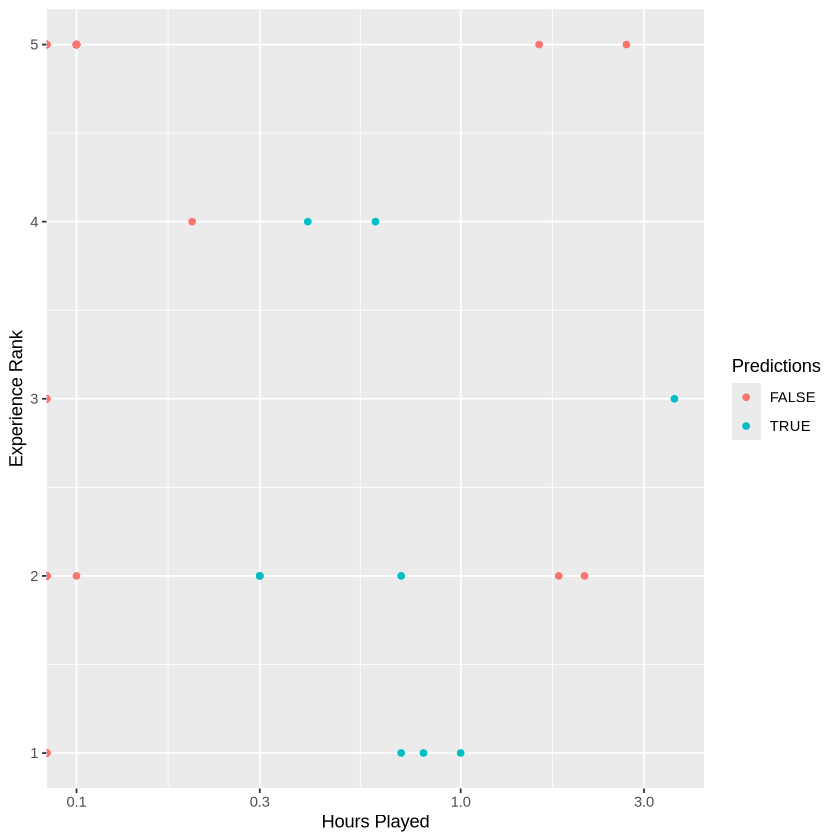

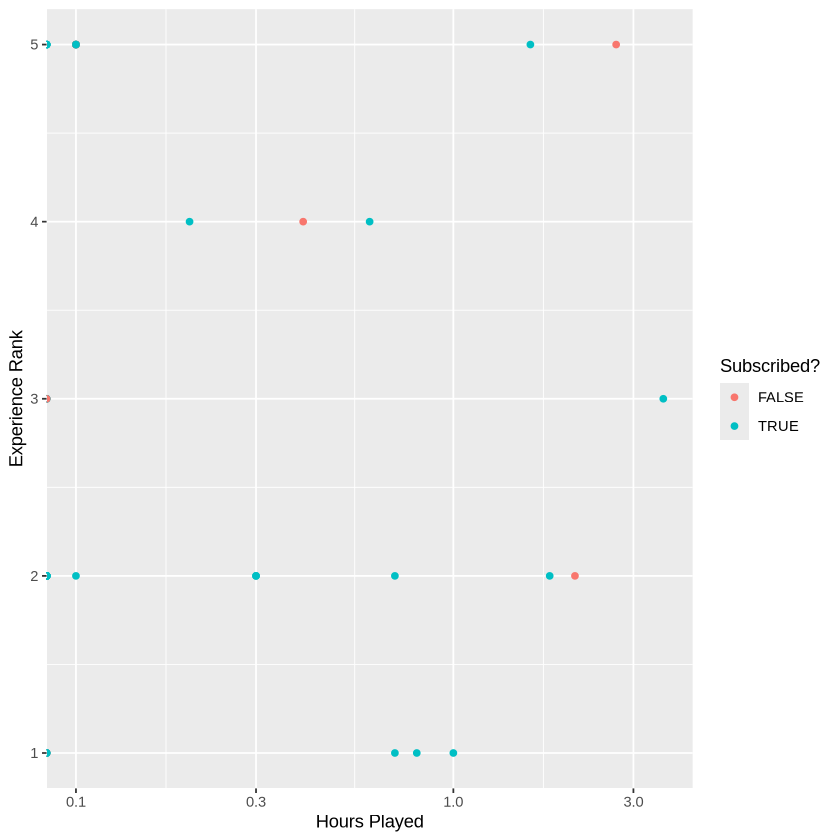

In [16]:
set.seed(12)
# Visualization
k_2_preds <- predictions_2 |>
    ggplot(aes(x = played_hours, y = experience, color = .pred_class)) +
    geom_point() +
    labs(x = "Hours Played", y = "Experience Rank", color = "Predictions") +
    scale_x_log10()
k_2_preds

k_2_real <- predictions_2 |>
    ggplot(aes(x = played_hours, y = experience, color = subscribe)) +
    geom_point() +
    labs(x = "Hours Played", y = "Experience Rank", color = "Subscribed?") +
    scale_x_log10()
k_2_real